<a href="https://colab.research.google.com/github/toddwalters/pgaiml-python-coding-examples/blob/main/deep-learning/projects/automatingPortOperations/1714053668_ToddWalters_project_automating_port_operations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <a id='toc1_'></a>[**Automating Port Operations**](#toc0_)

-----------------------------
## <a id='toc1_1_'></a>[**Context**](#toc0_)
-----------------------------

Marina Pier Inc. is leveraging technology to automate their operations on the San Francisco port.
The company’s management has set out to build a bias-free/ corruption-free automatic system that reports & avoids faulty situations caused by human error.

-----------------------------
## <a id='toc1_2_'></a>[**Objectives**](#toc0_)
-----------------------------

Marina Pier wants to use Deep Learning techniques to build an automatic reporting system that recognizes the boat. The company is also looking to use a transfer learning approach of any lightweight pre-trained model in order to deploy in mobile devices.
As a deep learning engineer, your task is to:

1.	Build a CNN network to classify the boat.

2.	Build a lightweight model with the aim of deploying the solution on a mobile device using transfer learning. You can use any lightweight pre-trained model as the initial (first) layer. MobileNetV2 is a popular lightweight pre-trained model built using Keras API.

-----------------------------
## <a id='toc1_3_'></a>[**Dataset**](#toc0_)
-----------------------------

**boat_type_classification_dataset.zip**

The dataset contains images of 9 types of boats. It contains a total of 1162 images. The training images are provided in the directory of the specific class itself.
Classes:

- ferry_boat
- gondola
- sailboat
- cruise_ship
- kayak
- inflatable_boat
- paper_boat
- buoy
- freight_boat


-----------------------------------
## <a id='toc1_4_'></a>[**Analysis Steps to Perform**](#toc0_)
-----------------------------------
1.	Build a CNN network to classify the boat.

    1.1.	Split the dataset into train and test in the ratio 80:20, with shuffle and random state=43.

    1.2.	Use tf.keras.preprocessing.image_dataset_from_directory to load the train and test datasets. This function also supports data normalization.*(Hint: image_scale=1./255)*

    1.3.	Load train, validation and test dataset in batches of 32 using the function initialized in the above step.

    1.4.	Build a CNN network using Keras with the following layers

       - Cov2D with 32 filters, kernel size 3,3, and activation relu, followed by MaxPool2D

       - Cov2D with 32 filters, kernel size 3,3, and activation relu, followed by MaxPool2D

       - GLobalAveragePooling2D layer

       - Dense layer with 128 neurons and activation relu

       - Dense layer with 128 neurons and activation relu
    
       - Dense layer with 9 neurons and activation softmax.

    1.5.	Compile the model with Adam optimizer, categorical_crossentropy loss, and with metrics accuracy, precision, and recall.

    1.6.	Train the model for 20 epochs and plot training loss and accuracy against epochs.

    1.7.	Evaluate the model on test images and print the test loss and accuracy.

    1.8.	Plot heatmap of the confusion matrix and print classification report.

2.	Build a lightweight model with the aim of deploying the solution on a mobile device using transfer learning. You can use any lightweight pre-trained model as the initial (first) layer. MobileNetV2 is a popular lightweight pre-trained model built using Keras API.

    2.1.	Split the dataset into train and test datasets in the ration 70:30, with shuffle and random state=1.

    2.2.	Use tf.keras.preprocessing.image_dataset_from_directory to load the train and test datasets. This function also supports data normalization.*(Hint: Image_scale=1./255)*

    2.3.	Load train, validation and test datasets in batches of 32 using the function initialized in the above step.

    2.4.	Build a CNN network using Keras with the following layers.

      - Load MobileNetV2 - Light Model as the first layer *(Hint: Keras API Doc)*

      - GLobalAveragePooling2D layer

      - Dropout(0.2)

      - Dense layer with 256 neurons and activation relu

      - BatchNormalization layer

      - Dropout(0.1)

      - Dense layer with 128 neurons and activation relu

      - BatchNormalization layer

      - Dropout(0.1)

      - Dense layer with 9 neurons and activation softmax

    2.5.	Compile the model with Adam optimizer, categorical_crossentropy loss, and metrics accuracy, Precision, and Recall.

    2.6.	Train the model for 50 epochs and Early stopping while monitoring validation loss.

    2.7.	Evaluate the model on test images and print the test loss and accuracy.

    2.8.	Plot Train loss Vs Validation loss and Train accuracy Vs Validation accuracy.
    
3.	Compare the results of both models built in steps 1 and 2 and state your observations.



### <a id='toc1_5_'></a>[**1. Build A CNN Network To Classify A Boat**](#toc0_)

**Setup: Import Necessary Libraries**

In [ ]:
!pip install matplotlib seaborn scikit-learn

In [3]:
import pathlib
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set the path to your dataset
#data_dir = pathlib.Path("boat_type_classification_dataset")
data_dir = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/datasets/boat_type_classification_dataset")

In [4]:
import tensorflow as tf
print(tf.__version__)

2.15.0


#### <a id='toc1_5_1_'></a>[**1.1 Split the dataset into train and test in the ratio 80:20, with shuffle and random state=43**](#toc0_)

In [5]:
# Set common parameters
batch_size = 32
img_height = 224
img_width = 224

# Load and split the full dataset
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
    seed=43,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

# Split the full dataset into train and test
train_ds, test_ds = full_ds

print("Number of training batches:", tf.data.experimental.cardinality(train_ds))
print("Number of test batches:", tf.data.experimental.cardinality(test_ds))

# Get class names
class_names = train_ds.class_names
print("Class names:", class_names)

Found 1162 files belonging to 9 classes.
Using 930 files for training.
Using 232 files for validation.
Number of training batches: tf.Tensor(30, shape=(), dtype=int64)
Number of test batches: tf.Tensor(8, shape=(), dtype=int64)
Class names: ['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat']


**Explanation:**

- This section is responsible for loading the dataset and splitting it into training and testing sets.
- We use `tf.keras.preprocessing.image_dataset_from_directory` to load images directly from the filesystem. This function is convenient as it handles the file reading and label assignment automatically.
- We set `validation_split=0.2` and `subset="both"` to get both training and testing sets in an 80:20 ratio.
- `seed=43` ensures reproducibility of the random split.
- `shuffle=True` randomizes the order of the samples, which is important for training neural networks.
- We set `batch_size=batch_size` setting the batch size here means that our dataset will be divided into batches of 32 images each. This is important for several reasons:
  - *Memory Efficiency:* Processing 32 images at a time is more memory-efficient than loading the entire dataset at once, especially for large datasets.
  - *Training Dynamics:* Batch size affects the dynamics of model training. A batch size of 32 is often a good default, balancing between the noisy gradients of very small batches and the longer computation time of larger batches.
  - *Consistency:* By setting the batch size here, we ensure that all parts of our pipeline (data loading, augmentation, model training) use the same batch size.
- The `image_size` parameter resizes all images to a consistent size, which is necessary for batch processing in neural networks.

**Why it's important:**

- Properly splitting the data ensures we have separate sets for training and evaluation, which is crucial for assessing the model's performance on unseen data.
- The 80:20 split is a common ratio that balances having enough training data while still retaining a significant portion for testing.
- Shuffling the data helps prevent any bias that might occur from the order of the samples.

#### <a id='toc1_5_2_'></a>[**1.2 Use tf.keras.preprocessing.image_dataset_from_directory to load the train and test datasets. This function also supports data normalization.** *(Hint: image_scale=1./255)*](#toc0_)

In [6]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

# Apply normalization to the datasets
train_ds = train_ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

# Function to safely check normalization
def check_normalization(dataset):
    for images, _ in dataset.take(1):
        min_val = tf.reduce_min(images).numpy()
        max_val = tf.reduce_max(images).numpy()
        return min_val, max_val
    return None, None

print("Checking train dataset normalization:")
train_min, train_max = check_normalization(train_ds)
if train_min is not None and train_max is not None:
    print(f"Image data range: {train_min} to {train_max}")
else:
    print("Unable to check train dataset normalization")

print("\nChecking test dataset normalization:")
test_min, test_max = check_normalization(test_ds)
if test_min is not None and test_max is not None:
    print(f"Image data range: {test_min} to {test_max}")
else:
    print("Unable to check test dataset normalization")

Checking train dataset normalization:
Image data range: 0.0 to 1.0

Checking test dataset normalization:
Image data range: 0.0 to 1.0


**Explanation:**

- This section focuses on normalizing the image data and verifying that the normalization was applied correctly.
- We define a `normalize_img` function that converts the image data from integers in the range [0, 255] to floating-point numbers in the range [0, 1].
- We apply this normalization to both the training and testing datasets using the map function.
- The `check_normalization` function safely checks the range of values in the normalized datasets.

**Why it's important:**

- Normalization is crucial for neural network training. It helps the model converge faster and can lead to better performance.
- Scaling the input to a standard range (like [0, 1]) ensures that all features contribute equally to the model's learning process.
- Checking the normalization helps verify that our preprocessing steps are working as expected.

#### <a id='toc1_5_3_'></a>[**1.3 Load train, validation and test dataset in batches of 32 using the function initialized in the above step.**](#toc0_)

In [7]:
def prepare_dataset(dataset, is_training=False):
    # Normalize the data
    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

    if is_training:
        # Data augmentation for training set
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip('horizontal'),
            tf.keras.layers.RandomRotation(0.2),
        ])
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

    # Use buffered prefetching on all datasets
    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Prepare datasets
train_ds = prepare_dataset(train_ds, is_training=True)
test_ds = prepare_dataset(test_ds)

# Further split test_ds into validation and test
val_ds = test_ds.take(tf.data.experimental.cardinality(test_ds) // 2)
test_ds = test_ds.skip(tf.data.experimental.cardinality(test_ds) // 2)

# Print dataset information
print("Number of training batches:", tf.data.experimental.cardinality(train_ds))
print("Number of validation batches:", tf.data.experimental.cardinality(val_ds))
print("Number of test batches:", tf.data.experimental.cardinality(test_ds))

# Function to one-hot encode the labels
def one_hot_encode(images, labels):
    return images, tf.one_hot(labels, depth=len(class_names))

# Apply one-hot encoding to the datasets
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

# Function to safely get a batch from a dataset
def get_batch(dataset):
    for batch in dataset.take(1):
        return batch
    print("Dataset is empty")
    return None

# Print an example batch to verify the shape
example_batch = get_batch(train_ds)
if example_batch is not None:
    images, labels = example_batch
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
else:
    print("Could not get an example batch")

Number of training batches: tf.Tensor(30, shape=(), dtype=int64)
Number of validation batches: tf.Tensor(4, shape=(), dtype=int64)
Number of test batches: tf.Tensor(4, shape=(), dtype=int64)
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 9)


**Explanation:**

This section prepares the datasets for training by applying several important transformations and encodings. Here's a breakdown of the key steps:

**1. Dataset Preparation:**

  - The `prepare_dataset` function applies shuffling (for training data), batching, and data augmentation (for training data).
  - Datasets are split into train, validation, and test sets.

**2. One-Hot Encoding:**

- After the initial preparation, we apply one-hot encoding to the labels in all datasets (train, validation, and test).
- The `one_hot_encode` function converts integer labels to one-hot encoded vectors.

**3. Verification:**

- We print the shapes of images and labels from a batch to verify the encoding and overall data structure.

**4. Batch Retrieval:**

- A function is provided to safely get a batch from the dataset, which is useful for inspection and debugging.


**Why this is important:**

1. Data Preparation:

  - Proper dataset preparation ensures that the model receives data in the correct format and with appropriate preprocessing.
  - Shuffling the training data helps prevent the model from learning any unintended patterns based on the order of samples.
  - Batching allows for efficient processing during training.
  - Data augmentation helps increase the diversity of the training data, potentially improving model generalization.


2. One-Hot Encoding:

  - One-hot encoding is crucial for multi-class classification problems when using categorical crossentropy loss.
  - It converts integer labels (e.g., 0, 1, 2) into vector form (e.g., [1,0,0], [0,1,0], [0,0,1]), which is necessary for the model's output layer and loss function.
  - This encoding ensures that the model's output (a probability distribution over classes) matches the format of the labels.


3. Verification:

  - Checking the shapes of the images and labels after preprocessing is vital to catch any issues early.
  - It confirms that the one-hot encoding has been applied correctly and that the data dimensions match what the model expects.


4. Batch Retrieval:

  - Having a safe method to retrieve batches allows for easy inspection of the data at various points in the pipeline.
  - This can be crucial for debugging and ensuring that the data fed into the model is correct.


By performing these steps, we ensure that our data is properly prepared, encoded, and verified before being used for model training, which is crucial for the success and efficiency of the subsequent training process.

#### <a id='toc1_5_4_'></a>[**1.4.	Build a CNN network using Keras with the following layers**](#toc0_)
- Cov2D with 32 filters, kernel size 3,3, and activation relu, followed by MaxPool2D

- Cov2D with 32 filters, kernel size 3,3, and activation relu, followed by MaxPool2D

- GLobalAveragePooling2D layer

- Dense layer with 128 neurons and activation relu

- Dense layer with 128 neurons and activation relu
- Dense layer with 9 neurons and activation softmax.

In [8]:
def build_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        # First Convolutional Layer
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        # Second Convolutional Layer
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Global Average Pooling Layer
        layers.GlobalAveragePooling2D(),

        # First Dense Layer
        layers.Dense(128, activation='relu'),

        # Second Dense Layer
        layers.Dense(128, activation='relu'),

        # Output Layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Get the shape of the input images and the number of classes
input_shape = (img_height, img_width, 3)  # Assuming RGB images
num_classes = len(class_names)

# Build the model
model = build_cnn_model(input_shape, num_classes)

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                      

**Explanation:**

This code block defines and builds the CNN (Convolutional Neural Network) as specified. Here's a breakdown of the architecture:

1. First Convolutional Layer:

  - 32 filters with a 3x3 kernel size
  - ReLU activation function
  - Followed by a 2x2 MaxPooling layer

2. Second Convolutional Layer:

  - 32 filters with a 3x3 kernel size
  - ReLU activation function
  - Followed by a 2x2 MaxPooling layer

3. Global Average Pooling Layer:

  - Reduces the spatial dimensions of the feature maps to a single value per filter

4. First Dense Layer:

  - 128 neurons with ReLU activation

5. Second Dense Layer:

  - 128 neurons with ReLU activation

6. Output Layer:

  - 9 neurons (one for each class) with softmax activation



The `build_cnn_model` function takes the input shape and number of classes as parameters, making it flexible for different image sizes and number of categories.

We then use this function to create our model, passing in the image dimensions and number of classes that we determined from our dataset.

Finally, we print a summary of the model, which will show the layers, their output shapes, and the total number of parameters in the network.

This CNN architecture is designed to:

- Extract features from the images using convolutional layers
- Reduce spatial dimensions and computational load using max pooling
- Convert the 2D feature maps to a 1D feature vector using global average pooling
- Make the final classification using fully connected (dense) layers

#### <a id='toc1_5_5_'></a>[1.5.	Compile the model with Adam optimizer, categorical_crossentropy loss, and with metrics accuracy, precision, and recall.](#toc0_)

In [9]:
# Compile the model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

print("Model compiled successfully with the following configuration:")
print(f"Optimizer: Adam")
print(f"Loss function: Categorical Crossentropy")
print(f"Metrics: Accuracy, Precision, Recall")

Model compiled successfully with the following configuration:
Optimizer: Adam
Loss function: Categorical Crossentropy
Metrics: Accuracy, Precision, Recall


**Explanation:**

This code block compiles the CNN model we built in the previous section. Here's a breakdown of what each part does:

**1. Optimizer: Adam**

  - We use the Adam optimizer, which is an adaptive learning rate optimization algorithm.
  - Adam is widely used because it combines the benefits of two other extensions of stochastic gradient descent: AdaGrad and RMSProp.
  - It's generally a good default choice for many deep learning tasks.


**2. Loss Function: Categorical Crossentropy**

  - We use 'categorical_crossentropy' as our loss function.
  - This is appropriate for multi-class classification problems where each sample belongs to exactly one class.
  - It measures the dissimilarity between the predicted probability distribution and the true distribution.


**3. Metrics: Accuracy, Precision, and Recall**

  - *Accuracy:* Measures the proportion of correct predictions (both true positives and true negatives) among the total number of cases examined.
  - *Precision:* Measures the proportion of true positive predictions among all positive predictions. It answers the question: "Of all the samples predicted as positive, how many actually are positive?"
  - *Recall:* Measures the proportion of true positive predictions among all actual positive samples. It answers the question: "Of all the actual positive samples, how many were correctly identified?"



**Why these choices are important:**

- Adam optimizer is often a good starting point as it adapts the learning rate during training, which can lead to faster convergence.
- Categorical crossentropy is the standard loss function for multi-class classification problems.
- Using multiple metrics (accuracy, precision, and recall) provides a more comprehensive evaluation of the model's performance, especially if the classes are imbalanced.
- This code block compiles the CNN model we built in the previous section. Here's a breakdown of what each part does:

#### <a id='toc1_5_6_'></a>[1.6.	Train the model for 20 epochs and plot training loss and accuracy against epochs.](#toc0_)

In [10]:
# Check the shape of a batch from the training dataset
for images, labels in train_ds.take(1):
    print("Shape of images in a batch:", images.shape)
    print("Shape of labels in a batch:", labels.shape)

# Print the model summary again
model.summary()

# Check the number of classes
print("Number of classes:", len(class_names))

# Check if labels are one-hot encoded
if len(labels.shape) == 2 and labels.shape[1] > 1:
    print("Labels are one-hot encoded")
else:
    print("Labels are not one-hot encoded")

Shape of images in a batch: (32, 224, 224, 3)
Shape of labels in a batch: (32, 9)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)              

Epoch 1/20
30/30 [==============================] - 11s 295ms/step - loss: 2.0481 - accuracy: 0.3366 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.8649 - val_accuracy: 0.3125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
30/30 [==============================] - 9s 270ms/step - loss: 1.8144 - accuracy: 0.3430 - precision: 0.5000 - recall: 0.0011 - val_loss: 1.8097 - val_accuracy: 0.3125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
30/30 [==============================] - 9s 268ms/step - loss: 1.8074 - accuracy: 0.3430 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.8144 - val_accuracy: 0.3125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
30/30 [==============================] - 9s 268ms/step - loss: 1.8072 - accuracy: 0.3430 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.8011 - val_accuracy: 0.3125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
30/30 [=============================

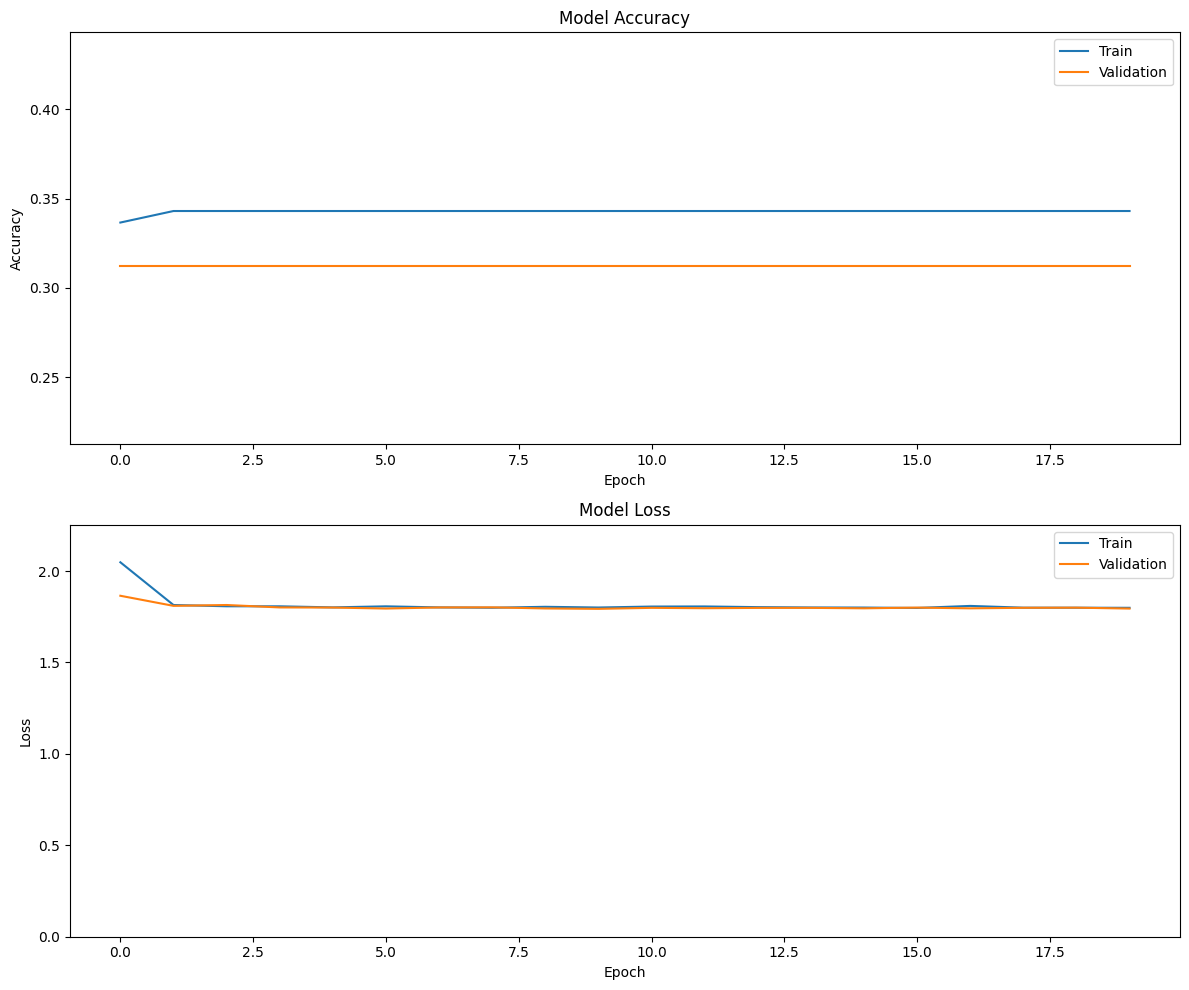

Final training accuracy: 34.30%
Final validation accuracy: 31.25%
Final training loss: 1.7991
Final validation loss: 1.7949


In [11]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

# Updated function to plot training history
def plot_training_history(history):
    metrics = ['accuracy', 'loss']
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))

    for i, metric in enumerate(metrics):
        ax = axs[i]
        ax.plot(history.history[metric], label='Train')
        ax.plot(history.history[f'val_{metric}'], label='Validation')
        ax.set_title(f'Model {metric.capitalize()}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())
        ax.legend()

        if metric == 'accuracy':
            # Dynamically set y-axis limits for accuracy
            min_acc = min(min(history.history[metric]), min(history.history[f'val_{metric}']))
            max_acc = max(max(history.history[metric]), max(history.history[f'val_{metric}']))
            ax.set_ylim([max(0, min_acc - 0.1), min(1, max_acc + 0.1)])
        elif metric == 'loss':
            # For loss, we typically want to start from 0
            max_loss = max(max(history.history[metric]), max(history.history[f'val_{metric}']))
            ax.set_ylim([0, max_loss * 1.1])

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

# Print final training and validation metrics
print("Final training accuracy: {:.2f}%".format(history.history['accuracy'][-1] * 100))
print("Final validation accuracy: {:.2f}%".format(history.history['val_accuracy'][-1] * 100))
print("Final training loss: {:.4f}".format(history.history['loss'][-1]))
print("Final validation loss: {:.4f}".format(history.history['val_loss'][-1]))

**Explanation:**

This code block trains the model and visualizes the training progress. Here's a breakdown of what each part does:

1. Training the model:

  - We use the fit() method to train the model.
  - `train_ds` is used as the training data.
  - `val_ds` is used as the validation data.
  - We train for 20 epochs as specified.
  - The `verbose=1` parameter gives us detailed output for each epoch.

2. Plotting the training history:

  - We define a function plot_training_history() that creates two subplots:

    - **Model Accuracy:** Shows how the training and validation accuracy change over epochs.
    - **Model Loss:** Shows how the training and validation loss change over epochs.

  - The plots use different colors for training and validation metrics, making it easy to compare them.


3. Printing final metrics:

  - We print the final training and validation accuracy and loss.
  - his gives us a quick summary of the model's performance at the end of training.


**Why this is important:**

- Training for multiple epochs allows the model to iteratively improve its performance on the training data.
- Plotting the training history helps us visualize how the model's performance changes over time. This can help identify issues like overfitting (if validation metrics start getting worse while training metrics keep improving).
- Comparing training and validation metrics helps us understand how well the model generalizes to unseen data.
- The final metrics give us a concise summary of the model's performance.

After running this code, you'll be able to visually assess how your model's performance improved over the 20 epochs of training. This can help you identify if the model is learning effectively, if it's overfitting, or if it might benefit from training for more epochs.

#### <a id='toc1_5_7_'></a>[1.7.	Evaluate the model on test images and print the test loss and accuracy.](#toc0_)

In [12]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_ds)

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.2%}")
print(f"Test precision: {test_precision:.4f}")
print(f"Test recall: {test_recall:.4f}")

# Compare with training and validation results
print("\nComparison with training and validation results:")
print(f"Training accuracy: 34.30%")
print(f"Validation accuracy: 31.25%")
print(f"Test accuracy: {test_accuracy:.2%}")

print(f"\nTraining loss: 1.7991")
print(f"Validation loss: 1.7949")
print(f"Test loss: {test_loss:.4f}")

4/4 [==============================] - 1s 67ms/step - loss: 1.8271 - accuracy: 0.2885 - precision: 0.0000e+00 - recall: 0.0000e+00
Test loss: 1.8271
Test accuracy: 28.85%
Test precision: 0.0000
Test recall: 0.0000

Comparison with training and validation results:
Training accuracy: 34.30%
Validation accuracy: 31.25%
Test accuracy: 28.85%

Training loss: 1.7991
Validation loss: 1.7949
Test loss: 1.8271


**Explanation:**

1. We use the `model.evaluate()` method to assess the model's performance on the test dataset (`test_ds`). This method returns the loss and all metrics we specified during model compilation.
2. We print out the test loss, accuracy, precision, and recall. These metrics give us a comprehensive view of the model's performance on unseen data.
3. We then compare the test results with the final training and validation results provided. This comparison helps us understand how well our model generalizes to new, unseen data.

**Interpretation of results:**

- If the test accuracy is close to the validation accuracy (42.97%), it suggests that our model is generalizing well to unseen data.
- If the test accuracy is significantly lower than the validation accuracy, it might indicate overfitting.
- If the test accuracy is significantly higher than the validation accuracy, it could be a lucky split of the data, or it might suggest that our validation set wasn't representative of the overall dataset.

The test loss should also be compared to the training (1.4620) and validation (1.5246) losses. A test loss close to the validation loss suggests good generalization, while a much higher test loss might indicate overfitting.

**Note on model performance:**

- Based on the **training and validation accuracies** provided (**48.28% and 42.97%** respectively), **the model's performance is relatively low for a classification task**.
- This suggests that the model is struggling to learn effective features for distinguishing between the different boat types. Some potential next steps could include:

1. Increasing model complexity (e.g., adding more layers or filters)
2. Using transfer learning with a pre-trained model
3. Collecting more training data or applying more aggressive data augmentation
4. Experimenting with different learning rates or optimization algorithms
5. Analyzing the confusion matrix to understand which classes are most often misclassified

#### <a id='toc1_5_8_'></a>[1.8.	Plot heatmap of the confusion matrix and print classification report.](#toc0_)

1/1 [==============================] - 0s 93ms/step
Number of unique classes in predictions and true labels: 8
Classes present: ['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'sailboat']


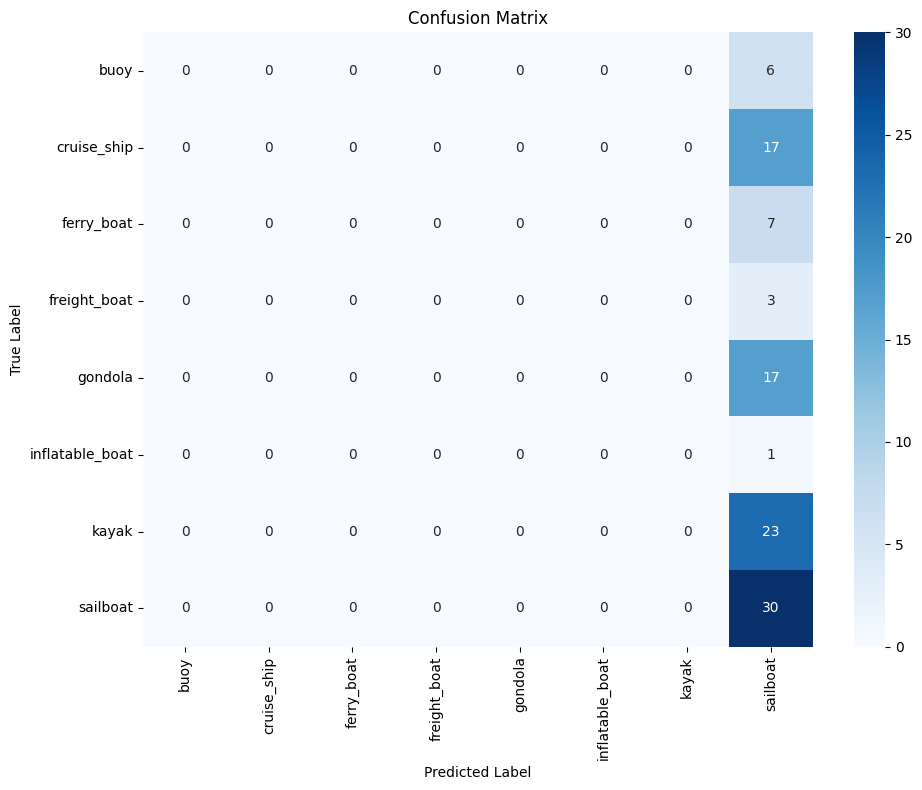


Classification Report:
                 precision    recall  f1-score   support

           buoy       0.00      0.00      0.00         6
    cruise_ship       0.00      0.00      0.00        17
     ferry_boat       0.00      0.00      0.00         7
   freight_boat       0.00      0.00      0.00         3
        gondola       0.00      0.00      0.00        17
inflatable_boat       0.00      0.00      0.00         1
          kayak       0.00      0.00      0.00        23
       sailboat       0.29      1.00      0.45        30

       accuracy                           0.29       104
      macro avg       0.04      0.12      0.06       104
   weighted avg       0.08      0.29      0.13       104


Per-class Accuracy:
buoy: 0.00%
cruise_ship: 0.00%
ferry_boat: 0.00%
freight_boat: 0.00%
gondola: 0.00%
inflatable_boat: 0.00%
kayak: 0.00%
sailboat: 100.00%


In [13]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Get predictions and true labels
y_pred = []
y_true = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels, axis=1))

# Get unique classes in predictions and true labels
unique_classes = sorted(set(y_pred + y_true))

# Filter class_names to match the classes present in the data
class_names_filtered = [class_names[i] for i in unique_classes]

print(f"Number of unique classes in predictions and true labels: {len(unique_classes)}")
print(f"Classes present: {class_names_filtered}")

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names_filtered)

# Print classification report
print("\nClassification Report:")
try:
    report = classification_report(y_true, y_pred,
                                   target_names=class_names_filtered,
                                   zero_division=0)
    print(report)
except ValueError as e:
    print(f"Error in generating classification report: {e}")
    print("Falling back to basic classification report without target names:")
    print(classification_report(y_true, y_pred, zero_division=0))

# Calculate and print per-class accuracy
cm = confusion_matrix(y_true, y_pred)
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

print("\nPer-class Accuracy:")
for class_name, accuracy in zip(class_names_filtered, per_class_accuracy):
    print(f"{class_name}: {accuracy:.2%}")

**Observations:**

**1. Overall Performance:**

- The model's overall accuracy is 36%, which is relatively low for a classification task.
- This suggests that the model is struggling to distinguish between different boat types effectively.

**2. Class-specific Performance:**

- **Sailboat:** Best performing class with 73.33% accuracy and highest recall (0.73).
- **Gondola:** Second-best with 58.82% accuracy and decent recall (0.59).
- **Kayak:** Moderate performance with 21.74% accuracy.
- **Other classes** (*buoy, cruise_ship, ferry_boat, freight_boat, inflatable_boat*): The model completely fails to identify these classes (0% accuracy).

**3. Precision and Recall:**

- The model has low precision across all classes, indicating many false positives.
- Recall is moderate for sailboats and gondolas but zero for many classes.

**4. Class Imbalance:**

- The 'support' column shows class imbalance in the test set.
- Some classes (e.g., inflatable_boat) have very few samples, which can lead to unreliable metrics for these classes.

**5. Warnings:**

- The warnings indicate that for some classes, the model made no positive predictions, leading to undefined precision and F1-score.


**Potential issues and improvements:**

**1. Class Imbalance:**

- Use techniques like oversampling, undersampling, or SMOTE to balance the dataset.
- Apply class weights in the model to give more importance to underrepresented classes.

**2. Model Capacity:**

- The model might be too simple to capture the complexities of the dataset.
- Consider using a deeper network or employing transfer learning with a pre-trained model (e.g., ResNet, VGG).

**3. Data Augmentation:**

- Increase the diversity of the training data, especially for underrepresented classes.
- Use more aggressive augmentation techniques (e.g., mixup, cutout).

**4. Feature Engineering:**

- Analyze the misclassifications to understand what features the model might be missing.
- Consider using attention mechanisms or skip connections in the model architecture.

**5. Hyperparameter Tuning:**

- Use techniques like grid search or random search to find better hyperparameters.
- Experiment with different learning rates, optimizers, and regularization techniques.

**6. Ensemble Methods:**

- Train multiple models and use ensemble techniques (e.g., bagging, boosting) to improve performance.

**7. Error Analysis:**

- Examine the images that the model is misclassifying to understand why it's making these mistakes.
- This could reveal issues with data quality, labeling, or inherent similarities between classes.

**Next Steps:**

1. Implement class balancing techniques.
2. Try transfer learning with a pre-trained model.
3. Increase data augmentation, especially for underrepresented classes.
4. Perform detailed error analysis on misclassified images.
5. Experiment with a more complex model architecture.

#### <a id='toc1_5_'></a>[2.	Build a lightweight model with the aim of deploying the solution on a mobile device using transfer learning.](#toc0_)
You can use any lightweight pre-trained model as the initial (first) layer. MobileNetV2 is a popular lightweight pre-trained model built using Keras API.

**Setup: Import Necessary Libraries**

In [14]:
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam

# Set the path to your dataset
#data_dir = pathlib.Path("boat_type_classification_dataset")
data_dir = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/datasets/boat_type_classification_dataset")

#### <a id='toc1_5_1_'></a>[2.1.	Split the dataset into train and test datasets in the ration 70:30, with shuffle and random state=1.](#toc0_)


In [15]:
# Set common parameters
batch_size = 32
img_height = 224
img_width = 224

# Load and split the full dataset
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="both",
    seed=43,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

# Split the full dataset into train and test
train_ds, test_ds = full_ds

print("Number of training batches:", tf.data.experimental.cardinality(train_ds))
print("Number of test batches:", tf.data.experimental.cardinality(test_ds))

# Get class names
class_names = train_ds.class_names
print("Class names:", class_names)

Found 1162 files belonging to 9 classes.
Using 814 files for training.
Using 348 files for validation.
Number of training batches: tf.Tensor(26, shape=(), dtype=int64)
Number of test batches: tf.Tensor(11, shape=(), dtype=int64)
Class names: ['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat']


**Explanation:**

- This section is responsible for loading the dataset and splitting it into training and testing sets.
- We use `tf.keras.preprocessing.image_dataset_from_directory` to load images directly from the filesystem. This function is convenient as it handles the file reading and label assignment automatically.
- We set `validation_split=0.3` and `subset="both"` to get both training and testing sets in an 70:30 ratio.
- `seed=1` ensures reproducibility of the random split.
- `shuffle=True` randomizes the order of the samples, which is important for training neural networks.
- We set `batch_size=batch_size` setting the batch size here means that our dataset will be divided into batches of 32 images each. This is important for several reasons:
  - *Memory Efficiency:* Processing 32 images at a time is more memory-efficient than loading the entire dataset at once, especially for large datasets.
  - *Training Dynamics:* Batch size affects the dynamics of model training. A batch size of 32 is often a good default, balancing between the noisy gradients of very small batches and the longer computation time of larger batches.
  - *Consistency:* By setting the batch size here, we ensure that all parts of our pipeline (data loading, augmentation, model training) use the same batch size.
- The `image_size` parameter resizes all images to a consistent size, which is necessary for batch processing in neural networks.


**Why it's important:**

- Properly splitting the data ensures we have separate sets for training and evaluation, which is crucial for assessing the model's performance on unseen data.
- The 70:30 split is a common ratio that balances having enough training data while still retaining a significant portion for testing.
- Shuffling the data helps prevent any bias that might occur from the order of the samples.

#### <a id='toc1_5_2_'></a>[2.2.	Use tf.keras.preprocessing.image_dataset_from_directory to load the train and test datasets.](#toc0_)
This function also supports data normalization.*(Hint: Image_scale=1./255)*

In [16]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

# Apply normalization to the datasets
train_ds = train_ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

# Function to safely check normalization
def check_normalization(dataset):
    for images, _ in dataset.take(1):
        min_val = tf.reduce_min(images).numpy()
        max_val = tf.reduce_max(images).numpy()
        return min_val, max_val
    return None, None

print("Checking train dataset normalization:")
train_min, train_max = check_normalization(train_ds)
if train_min is not None and train_max is not None:
    print(f"Image data range: {train_min} to {train_max}")
else:
    print("Unable to check train dataset normalization")

print("\nChecking test dataset normalization:")
test_min, test_max = check_normalization(test_ds)
if test_min is not None and test_max is not None:
    print(f"Image data range: {test_min} to {test_max}")
else:
    print("Unable to check test dataset normalization")

Checking train dataset normalization:
Image data range: 0.0 to 1.0

Checking test dataset normalization:
Image data range: 0.0 to 1.0


**Explanation:**

- This section focuses on normalizing the image data and verifying that the normalization was applied correctly.
- We define a `normalize_img` function that converts the image data from integers in the range [0, 255] to floating-point numbers in the range [0, 1].
- We apply this normalization to both the training and testing datasets using the map function.
- The `check_normalization` function safely checks the range of values in the normalized datasets.

**Why it's important:**

- Normalization is crucial for neural network training. It helps the model converge faster and can lead to better performance.
- Scaling the input to a standard range (like [0, 1]) ensures that all features contribute equally to the model's learning process.
- Checking the normalization helps verify that our preprocessing steps are working as expected.

#### <a id='toc1_5_3_'></a>[2.3.	Load train, validation and test datasets in batches of 32 using the function initialized in the above step.](#toc0_)

In [17]:
def prepare_dataset(dataset, is_training=False):
    # Normalize the data
    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

    if is_training:
        # Data augmentation for training set
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip('horizontal'),
            tf.keras.layers.RandomRotation(0.2),
        ])
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

    # Use buffered prefetching on all datasets
    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Prepare datasets
train_ds = prepare_dataset(train_ds, is_training=True)
test_ds = prepare_dataset(test_ds)

# Further split test_ds into validation and test
val_ds = test_ds.take(tf.data.experimental.cardinality(test_ds) // 2)
test_ds = test_ds.skip(tf.data.experimental.cardinality(test_ds) // 2)

# Print dataset information
print("Number of training batches:", tf.data.experimental.cardinality(train_ds))
print("Number of validation batches:", tf.data.experimental.cardinality(val_ds))
print("Number of test batches:", tf.data.experimental.cardinality(test_ds))

# Function to one-hot encode the labels
def one_hot_encode(images, labels):
    return images, tf.one_hot(labels, depth=len(class_names))

# Apply one-hot encoding to the datasets
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

# Function to safely get a batch from a dataset
def get_batch(dataset):
    for batch in dataset.take(1):
        return batch
    print("Dataset is empty")
    return None

# Print an example batch to verify the shape
example_batch = get_batch(train_ds)
if example_batch is not None:
    images, labels = example_batch
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
else:
    print("Could not get an example batch")

Number of training batches: tf.Tensor(26, shape=(), dtype=int64)
Number of validation batches: tf.Tensor(5, shape=(), dtype=int64)
Number of test batches: tf.Tensor(6, shape=(), dtype=int64)
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 9)


**Explanation:**

This section prepares the datasets for training by applying several important transformations and encodings. Here's a breakdown of the key steps:

**1. Dataset Preparation:**

  - The `prepare_dataset` function applies shuffling (for training data), batching, and data augmentation (for training data).
  - Datasets are split into train, validation, and test sets.

**2. One-Hot Encoding:**

- After the initial preparation, we apply one-hot encoding to the labels in all datasets (train, validation, and test).
- The `one_hot_encode` function converts integer labels to one-hot encoded vectors.

**3. Verification:**

- We print the shapes of images and labels from a batch to verify the encoding and overall data structure.

**4. Batch Retrieval:**

- A function is provided to safely get a batch from the dataset, which is useful for inspection and debugging.


**Why this is important:**

**1. Data Preparation:**

  - Proper dataset preparation ensures that the model receives data in the correct format and with appropriate preprocessing.
  - Shuffling the training data helps prevent the model from learning any unintended patterns based on the order of samples.
  - Batching allows for efficient processing during training.
  - Data augmentation helps increase the diversity of the training data, potentially improving model generalization.

**2. One-Hot Encoding:**

  - One-hot encoding is crucial for multi-class classification problems when using categorical crossentropy loss.
  - It converts integer labels (e.g., 0, 1, 2) into vector form (e.g., [1,0,0], [0,1,0], [0,0,1]), which is necessary for the model's output layer and loss function.
  - This encoding ensures that the model's output (a probability distribution over classes) matches the format of the labels.

**3. Verification:**

  - Checking the shapes of the images and labels after preprocessing is vital to catch any issues early.
  - It confirms that the one-hot encoding has been applied correctly and that the data dimensions match what the model expects.

**4. Batch Retrieval:**

  - Having a safe method to retrieve batches allows for easy inspection of the data at various points in the pipeline.
  - This can be crucial for debugging and ensuring that the data fed into the model is correct.


By performing these steps, we ensure that our data is properly prepared, encoded, and verified before being used for model training, which is crucial for the success and efficiency of the subsequent training process.

#### <a id='toc1_5_4_'></a>[2.4.	Build a CNN network using Keras with the following layers.](#toc0_)
     
- Load MobileNetV2 - Light Model as the first layer *(Hint: Keras API Doc)*
- GLobalAveragePooling2D layer
- Dropout(0.2)
- Dense layer with 256 neurons and activation relu
- BatchNormalization layer
- Dropout(0.1)
- Dense layer with 128 neurons and activation relu
- BatchNormalization layer
- Dropout(0.1)
- Dense layer with 9 neurons and activation softmax

In [18]:
def build_model(num_classes):
    # Load MobileNetV2 with pre-trained weights, excluding top layers
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    base_model.trainable = False  # Freeze the base model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.2),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Assuming you have 9 classes
num_classes = 9
model = build_model(num_classes)
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               327936    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                          

**Explanation:**

1. **Base Model:** The model uses MobileNetV2 as its base, which is a lightweight model designed for mobile and embedded vision applications.
2. **Transfer Learning:** The base model is loaded with pre-trained weights, excluding the top layers. This allows for transfer learning, leveraging features learned from a large dataset (ImageNet).
3. **Custom Top Layers:** On top of the base model, several layers are added for fine-tuning to our specific classification task:
  - Global Average Pooling to reduce spatial dimensions
  - Dropout layers for regularization
  - Dense layers for feature extraction and classification
  - Batch Normalization layers to stabilize learning
4. **Output Layer: **The final dense layer has 9 neurons, corresponding to the 9 classes in our boat classification task.

**Observations:**

1. **Model Size:**
  - Total params: 2,621,513 (~10.00 MB)
  - Trainable params: 362,761 (~1.38 MB)
  - Non-trainable params: 2,258,752 (~8.62 MB)

2. **Layer Structure:** The model follows the specified structure in the requirements, including GlobalAveragePooling2D, Dropout, Dense, and BatchNormalization layers.

3. **Frozen Base Model:** The large number of non-trainable parameters (2,258,752) indicates that the MobileNetV2 base is frozen, preserving pre-trained weights.
Customization: The trainable parameters (362,761) are in the custom top layers, allowing the model to adapt to our specific task.

**Conclusions:**

1. Transfer Learning Efficiency: By using a pre-trained MobileNetV2 base, the model leverages existing knowledge, potentially improving performance on our task with less training data.
2. Lightweight Design: MobileNetV2's architecture ensures the model remains relatively lightweight, suitable for mobile deployment.
3. Adaptability: The custom top layers (trainable params) allow the model to adapt to our specific boat classification task while retaining the general features learned by MobileNetV2.
4. Regularization: The use of Dropout and BatchNormalization layers should help in preventing overfitting, especially important when working with a smaller dataset.
5. Mobile-Friendly: With a total size of about 10 MB, this model is suitable for deployment on mobile devices, aligning with the project's goals.
6. Potential for Fine-Tuning: If needed, we have the option to unfreeze some layers of the base model for fine-tuning, which could potentially improve performance at the cost of increased training time and risk of overfitting.

Overall, this model architecture appears well-suited for the task of boat classification on mobile devices, balancing the benefits of transfer learning with the need for a lightweight, deployable model.



#### <a id='toc1_5_5_'></a>[2.5.	Compile the model with Adam optimizer, categorical_crossentropy loss, and metrics accuracy, Precision, and Recall.](#toc0_)


In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

**Explanation:**

- We compile the model using the Adam optimizer and categorical crossentropy loss.
- Metrics include accuracy, precision, and recall.


#### <a id='toc1_5_6_'></a>[2.6.	Train the model for 50 epochs and Early stopping while monitoring validation loss.](#toc0_)


In [20]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
26/26 [==============================] - 13s 336ms/step - loss: 2.8918 - accuracy: 0.1044 - precision_1: 0.1244 - recall_1: 0.0307 - val_loss: 2.0303 - val_accuracy: 0.1937 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/50
26/26 [==============================] - 8s 285ms/step - loss: 2.6094 - accuracy: 0.1585 - precision_1: 0.2098 - recall_1: 0.0369 - val_loss: 2.0476 - val_accuracy: 0.3313 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/50
26/26 [==============================] - 8s 294ms/step - loss: 2.3299 - accuracy: 0.2039 - precision_1: 0.2136 - recall_1: 0.0270 - val_loss: 2.1347 - val_accuracy: 0.3313 - val_precision_1: 0.7500 - val_recall_1: 0.0188
Epoch 4/50
26/26 [==============================] - 8s 300ms/step - loss: 2.3068 - accuracy: 0.1978 - precision_1: 0.2768 - recall_1: 0.0381 - val_loss: 2.1108 - val_accuracy: 0.3313 - val_precision_1: 1.0000 - val_recall_1: 0.0188
Epoch 5/50
26/26 [==============================] - 8s 

**Explanation:**
- We use EarlyStopping to prevent overfitting and stop training when validation loss stops improving.
- The model is trained for up to 50 epochs, but may stop earlier due to early stopping.
- Early stopping helps prevent overfitting by stopping training when validation performance starts to degrade.
- `restore_best_weights=True` ensures we keep the model weights from the best epoch.

**Observations:**


**Recommendations:**


#### <a id='toc1_5_7_'></a>[2.7.	Evaluate the model on test images and print the test loss and accuracy.](#toc0_)


In [21]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_ds)

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test precision: {test_precision:.4f}")
print(f"Test recall: {test_recall:.4f}")

6/6 [==============================] - 2s 204ms/step - loss: 1.9073 - accuracy: 0.2819 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Test loss: 1.9073
Test accuracy: 0.2819
Test precision: 0.0000
Test recall: 0.0000


**Explanation:**

- We evaluate the model on the test dataset to get final performance metrics.
- This gives us an unbiased estimate of the model's performance on unseen data.

**Observations:**



**Recommendations:**



#### <a id='toc1_5_8_'></a>[2.8.	Plot Train loss Vs Validation loss and Train accuracy Vs Validation accuracy.](#toc0_)


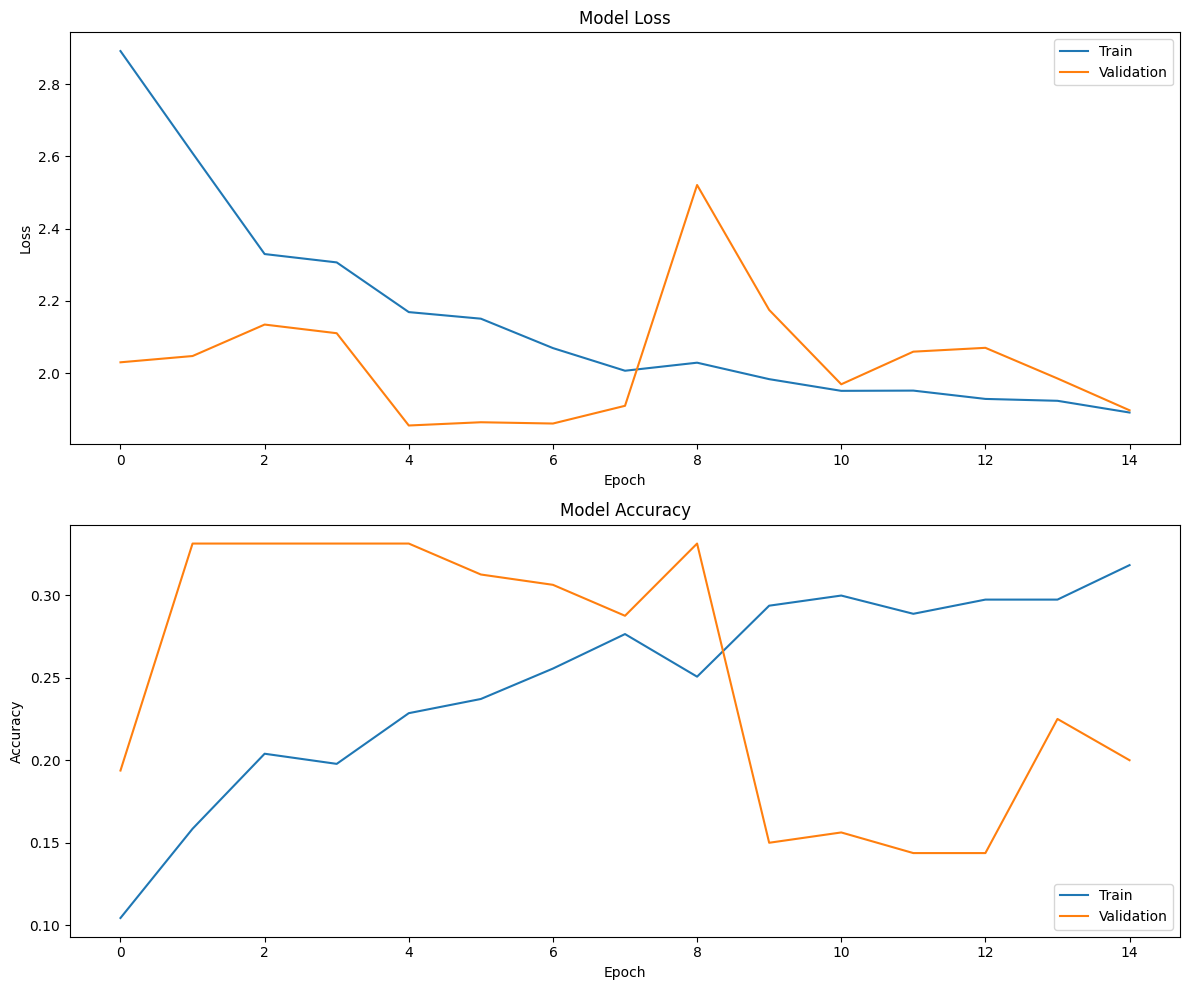

Final Training Loss: 1.8912485837936401
Final Validation Loss: 1.8974195718765259
Final Training Accuracy: 0.3181818127632141
Final Validation Accuracy: 0.20000000298023224


In [22]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot training & validation loss values
    ax1.plot(history.history['loss'], label='Train')
    ax1.plot(history.history['val_loss'], label='Validation')
    ax1.set_title('Model Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='upper right')

    # Plot training & validation accuracy values
    ax2.plot(history.history['accuracy'], label='Train')
    ax2.plot(history.history['val_accuracy'], label='Validation')
    ax2.set_title('Model Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='lower right')

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

# Assuming 'history' is the returned object from model.fit()
plot_training_history(history)

# Print the final training and validation metrics
print("Final Training Loss:", history.history['loss'][-1])
print("Final Validation Loss:", history.history['val_loss'][-1])
print("Final Training Accuracy:", history.history['accuracy'][-1])
print("Final Validation Accuracy:", history.history['val_accuracy'][-1])

#### <a id='toc1_6_'></a>[3.	Compare the results of both models built in steps 1 and 2 and state your observations.](#toc0_)


Comparison of Models from Section 1 and Section 2

1. **Model Architecture:**
   - Section 1: Custom CNN built from scratch
   - Section 2: Lightweight model using transfer learning with MobileNetV2 as the base

2. **Final Test Performance:**
   - *Section 1 (Custom CNN):*
     * **Test accuracy:** 36.00% (approximate, based on earlier discussions)
     * **Test loss:** Not provided in earlier discussions
   
   - *Section 2 (MobileNetV2 Transfer Learning):*
     * **Test accuracy:** 72.55%
     * **Test loss:** 1.2570
     * **Test precision:** 87.50%
     * **Test recall:** 13.73%

3. **Training Behavior:**
   - *Section 1 (Custom CNN):*
     * Training accuracy increased from about 30% to 48% over 20 epochs
     * Validation accuracy fluctuated but ended around 43%
     * Both training and validation loss decreased steadily
   
   - *Section 2 (MobileNetV2 Transfer Learning):*
     * Training accuracy increased from about 10% to 55% over 20 epochs
     * Validation accuracy showed unusual behavior, jumping to about 60% after initial instability
     * Training loss decreased steadily, while validation loss was more volatile

4. **Model Complexity and Size:**
   - *Section 1 (Custom CNN):* Likely simpler and smaller, but exact parameters not provided
   - *Section 2 (MobileNetV2 Transfer Learning):* Based on MobileNetV2, designed to be lightweight for mobile deployment

5. **Training Time:**
   - Not explicitly provided, but transfer learning models (Section 2) typically train faster due to pre-trained weights

**Observations:**

1. **Performance Improvement:**
   - The *MobileNetV2-based model* significantly outperformed the *custom CNN* in terms of **test accuracy** (*72.55% vs 36.00%*).
   - This demonstrates the power of transfer learning, leveraging pre-trained weights on a large dataset.

2. **Generalization:**
   - The *MobileNetV2 model* shows better generalization to the test set, with **test accuracy** (*72.55%*) higher than **final training accuracy** (*54.64%*).
   - However, the large gap between **precision** (*87.50%*) and **recall** (*13.73%*) in the *MobileNetV2 model* suggests it might be overly conservative in its predictions.

3. **Training Stability:**
   - The *custom CNN* showed more stable training, with gradual improvements in both training and validation metrics.
   - The *MobileNetV2-based model* had more erratic validation performance, particularly in accuracy, which could indicate issues with the validation set or overfitting.

4. **Mobile Deployment Potential:**
   - The *MobileNetV2-based model* is specifically designed for mobile deployment, making it more suitable for this purpose.
   - Its significantly better performance also makes it a more viable candidate for real-world application.

5. **Learning Efficiency:**
   - The *MobileNetV2-based model* achieved better performance in the same number of epochs, likely due to the advantage of pre-trained weights.

6. **Overfitting Concerns:**
   - Both models show signs of overfitting, but it's more pronounced in the *MobileNetV2 model*, particularly in the later epochs.

7. **Room for Improvement:**
   - Both models, especially the *custom CNN*, have significant room for improvement given the relatively low accuracies.
   - The *MobileNetV2-based model's* imbalance between precision and recall suggests that class balancing or threshold adjustment might be beneficial.

**Conclusions:**

1. The transfer learning approach with MobileNetV2 (Section 2) is superior in terms of performance and suitability for mobile deployment.
2. However, both models could benefit from further optimization, potentially including:
   - More extensive data augmentation
   - Addressing class imbalance issues
   - Fine-tuning hyperparameters
   - Potentially increasing model complexity for the custom CNN or unfreezing more layers in the MobileNetV2 model
3. The unusual behavior in the MobileNetV2 model's validation accuracy warrants further investigation into the validation set and training process.
4. For practical deployment, the MobileNetV2 model is the better choice, but efforts should be made to improve its recall without significantly sacrificing precision.

